In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration, filters
from scipy import ndimage, linalg, optimize


class Height_map():
    
    def __init__(self,
                 n_glass = 1.525,
                 n_water = 1.333,
                 n_outer = 1.335,
                 n_lipid = 1.486,
                 n_inner = 1.344,
                 d_water = 1,
                 d_lipid = 4,
                 l = 546):
       
        # Parameters
        self.n_glass = n_glass      #refractive index of glass 
        self.n_water = n_water      #refractive index of water
        self.n_outer = n_outer      #refractive index of outer solution (PBS)
        self.n_lipid = n_lipid      #refractive index of lipid
        self.n_inner = n_inner      #refractive index of inner buffer (Sucrose)
        
        self.d_water = d_water      #thikness of water in nm
        self.d_lipid = d_lipid      #thikness of lipid in nm
        
        self.l = l                  #wave length of the RICM light in nm
        

    # Normalized reflactance for 5 interfaces
    def R5_norm(self, h):

        # Wave vector
        k = (2 * np.pi) / self.l

        # Refractive indices
        n0 = self.n_glass    # Glass slid
        n1 = self.n_water    # Layer of water down the SLB
        n2 = self.n_lipid    # SLB 
        n3 = self.n_outer    # Outer buffer PBS
        n4 = self.n_lipid    # Vesicle membrane
        n5 = self.n_inner    # Inner buffer Sucrose

        # Fresnel reflection coefficients
        r01 = (n0 - n1) / (n0 + n1)
        r12 = (n1 - n2) / (n1 + n2)
        r23 = (n2 - n3) / (n2 + n3)
        r34 = (n3 - n4) / (n3 + n4)
        r45 = (n4 - n5) / (n4 + n5)

        # Distances traveled by light
        D1 = 2 * n1 * self.d_water
        D2 = 2 * n2 * self.d_lipid
        D3 = 2 * n3 * h
        D4 = 2 * n4 * self.d_lipid  

        # Effective reflection coefficient of the adhesion zone
        R = r01 + ((1-r01**2) * np.exp(-1j*k*D1)) * r12 + ((1-r01**2)*(1-r12**2) * np.exp(-1j*k*(D1+D2))) * r23 + ((1-r01**2)*(1-r12**2)*(1-r23**2) * np.exp(-1j*k*(D1+D2+D3))) * r34 + ((1-r01**2)*(1-r12**2)*(1-r23**2)*(1-r34**2) * np.exp(-1j*k*(D1+D2+D3+D4))) * r45

        # Effective reflection coefficient of the background
        R_b = r01 + ((1-r01**2) * np.exp(-1j*k*D1)) * r12 + ((1-r01**2)*(1-r12**2) * np.exp(-1j*k*(D1 + D2))) * r23

        # Normalized reflactance R_norm
        R_norm = np.abs(R * np.conjugate(R)) / np.abs(R_b * np.conjugate(R_b))

        return R_norm
    
    # Normalized reflactance for 5 interfaces
    def R5_norm_old(self, h):

        # Wave vector
        k = 2 * np.pi / self.l

        # distance
        d = np.array([1, self.d_water, self.d_lipid, h, self.d_lipid])

        # Refractive indices
        n = np.array([self.n_glass, self.n_water, self.n_lipid, self.n_outer, self.n_lipid, self.n_inner])

        # Distance traveled by the lite 
        D = np.array([2 * n[i] * d[i] for i in range(len(d))])

        # Fresnel reflection coefficient
        r = np.array([(n[i] - n[i+1]) / (n[i] + n[i+1]) for i in range(len(n)-1)])

        # Reflactance R
        P = np.array([
            1,
            (1-r[0]**2) * np.exp(-1J * k * D[1]),
            (1-r[0]**2)*(1-r[1]**2) * np.exp(-1J * k * (D[1]+D[2])),
            (1-r[0]**2)*(1-r[1]**2)*(1-r[2]**2) * np.exp(-1J * k * (D[1]+D[2]+D[3])),
            (1-r[0]**2)*(1-r[1]**2)*(1-r[2]**2)*(1-r[3]**2) * np.exp(-1J * k * (D[1]+D[2]+D[3]+D[4]))
        ])

        R = np.sum(P * r)
        
        # Take it's real absolute value
        R = np.abs(R * np.conjugate(R))

        # Reflactance R_background
        P_background = np.array([
            1,
            (1-r[0]**2) * np.exp(-1J * k * D[1]),
            (1-r[0]**2)*(1-r[1]**2) * np.exp(-1J * k * (D[1]+D[2]))
        ])

        r_background = np.array([r[0], r[1], r[2]])

        R_background = np.sum(P_background * r_background)
        
        # Take it's real absolute value
        R_background = np.abs(R_background * np.conjugate(R_background))

        return (R - R_background) / R_background


    # The dependence of the normalized intensity on hight
    def normalized_intensity(self, h, Y0, A, h0):
        
        n_outer = self.n_outer  #refractive index of PBS
        l = self.l              #wave length of the RICM light

        return Y0 - A * np.cos((4 * np.pi * n_outer / l) * (h - h0))
    


class RICM(Height_map):
    
    def __init__(self,
                 img,
                 denoise = True, nl_fast_mode = True, nl_patch_size = 10, nl_patch_distance = 10,
                 hole = 3,
                 n_glass = 1.525, n_water = 1.33, n_outer = 1.33, n_lipid = 1.486, n_inner = 1.38,
                 d_water = 1, d_lipid = 4, l = 546):
        
        Height_map.__init__(self,
                            n_glass = 1.525, n_water = 1.33, n_outer = 1.33, n_lipid = 1.486, n_inner = 1.38,
                            d_water = 1, d_lipid = 4, l = 546)
        
        self.img = img
        self.denoise = denoise
        self.nl_fast_mode = nl_fast_mode
        self.nl_patch_size = nl_patch_size
        self.nl_patch_distance = nl_patch_distance
        self.hole = hole
        
    # Denoise the image using Non-local means denoising algorithm
    def nl_denoise(self):

        #Estimating the noise variance of the image
        sigma_est = np.mean(restoration.estimate_sigma(self.img , multichannel = False))

        #Apply the Non-local means denoising algorithm
        img_denoised = restoration.denoise_nl_means(self.img,
                                                    h = sigma_est,
                                                    fast_mode = self.nl_fast_mode,
                                                    patch_size = self.nl_patch_size,
                                                    patch_distance = self.nl_patch_distance,
                                                    multichannel = False)
        return img_denoised


    # Detecting the edges
    def edge_detection(self):
        
        if self.denoise == True:
            #Apply the Non-local means denoising algorithm
            img_denoised = RICM.nl_denoise(self)

            #Applying some edge operators to the denoised image
            edge = filters.sobel(img_denoised)
        else:
            #Applying some edge operators to the original image
            edge = filters.sobel(self.img)

        return edge

    # Determine the contact zone by filling the closed edges inside the binary image of the edges
    def mask(self):

        #Applying some edge operators to the denoised image
        edge = RICM.edge_detection(self)

        # Getting the threshold of edge filtered image
        edge_threshold = filters.threshold_otsu(edge)

        # Making a binary image with 0 and 1 values
        edge_binary = np.multiply(edge > edge_threshold, 1)

        return ndimage.binary_fill_holes(edge_binary, structure=np.ones((self.hole, self.hole)))


    # Fitting the background
    def background_fitting(self):

        # Determine the contact zone
        edge_binary_filled = RICM.mask(self)

        # Write the data in terms of 3-dim points excluding the contact zone
        coord_background_intensity = []
        for i in range(self.img.shape[0]):
            for j in range(self.img.shape[1]):
                if edge_binary_filled[i, j] == False:  # excluding the contact zone
                    coord_background_intensity.append([i, j, self.img[i,j]])

        # 3-dim data points
        data = np.array(coord_background_intensity)

        # best-fit quadratic curve
        A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
        C,_,_,_ = linalg.lstsq(A, data[:,2])

        # Copy the original img
        Background = np.ones(self.img.shape)

        # Fill the bacground with the values came from the fitting
        for X in range(self.img.shape[0]):
            for Y in range(self.img.shape[1]):
                Background[X,Y] = C[0] + C[1]*X + C[2]*Y + C[3]*X*Y + C[4]*X*X + C[5]*Y*Y

        return Background


    # Correcting the image by subtracting the background then add it's average to each pixel
    def correct(self):

        # Fitting the background
        Background = RICM.background_fitting(self)

        # Take the average of the bacground
        avg_background = np.average(Background)

        return self.img - Background + avg_background

    # Normalized reflactance to the background
    def background_normalization(self):

        # Determine the contact zone
        edge_binary_filled = RICM.mask(self)

        # Get the corrected image
        img_corrected = RICM.correct(self)

        # Get the background average of the corrected image
        background_corrected_intensities = []
        for i in range(self.img.shape[0]):
            for j in range(self.img.shape[1]):
                if edge_binary_filled[i, j] == False:  # excluding the contact zone
                    background_corrected_intensities.append(img_corrected[i,j])

        # Take the average of the corrected bacground
        avg_corrected_background = np.average(background_corrected_intensities)

        return img_corrected / avg_corrected_background
    
    
    # RICM height mapping
    def height(self, h = np.linspace(1, 600, 600)):
        
        # Normalized reflactance to the background
        img_background_normalized =  RICM.background_normalization(self)
        

        # Fit the parameters Y_0, A, h_0 of the cosine function
        mapping = Height_map()
        popt, pcov = optimize.curve_fit(mapping.normalized_intensity, h, mapping.R5_norm(h))
        Y0, A, h0 = popt
        print('Y0 = {:.2f}, A = {:.2f}, h0 = {:.2f}'.format(*popt))

        return (self.l / (4 * np.pi * self.n_outer)) * np.arccos((Y0 - img_background_normalized) / A) + h0    
    
    # RICM height mapping argument
    def height_argument(self, h = np.linspace(1, 600, 600)):
        
        # Normalized reflactance to the background
        img_background_normalized =  RICM.background_normalization(self)
        

        # Fit the parameters Y_0, A, h_0 of the cosine function
        mapping = Height_map()
        popt, pcov = optimize.curve_fit(mapping.normalized_intensity, h, mapping.R5_norm(h))
        Y0, A, h0 = popt
        print('Y0 = {:.2f}, A = {:.2f}, h0 = {:.2f}'.format(*popt))

        return (Y0 - img_background_normalized) / A

In [2]:
# Libraries
import numpy as np
from skimage import io
from PIL import Image


# Modules
#from RICM_vesicle import RICM

# Read the image
img = io.imread("data/AVG_20161025_dsDNA_SC_36nm_Conc_6.00nM_WOC_Sample_D_03_RICMS_00-1.tif")

# Define the RICM class with certain n_inner
ricm = RICM(img, n_inner = 1.344)

# Save the results
Image.fromarray(img).save('results/original.tif')
Image.fromarray(ricm.nl_denoise()).save('results/nl_denoise.tif')
Image.fromarray(ricm.edge_detection()).save('results/edge_detection.tif')
Image.fromarray(ricm.mask()).save('results/mask.tif')
Image.fromarray(ricm.background_fitting()).save('results/background_fitting.tif')
Image.fromarray(ricm.correct()).save('results/correct.tif')
Image.fromarray(ricm.background_normalization()).save('results/background_normalization.tif')
Image.fromarray(ricm.height()).save('results/height.tif')

Y0 = 1.01, A = 0.24, h0 = 32.11


Y0 = 1.01, A = 0.24, h0 = 32.11


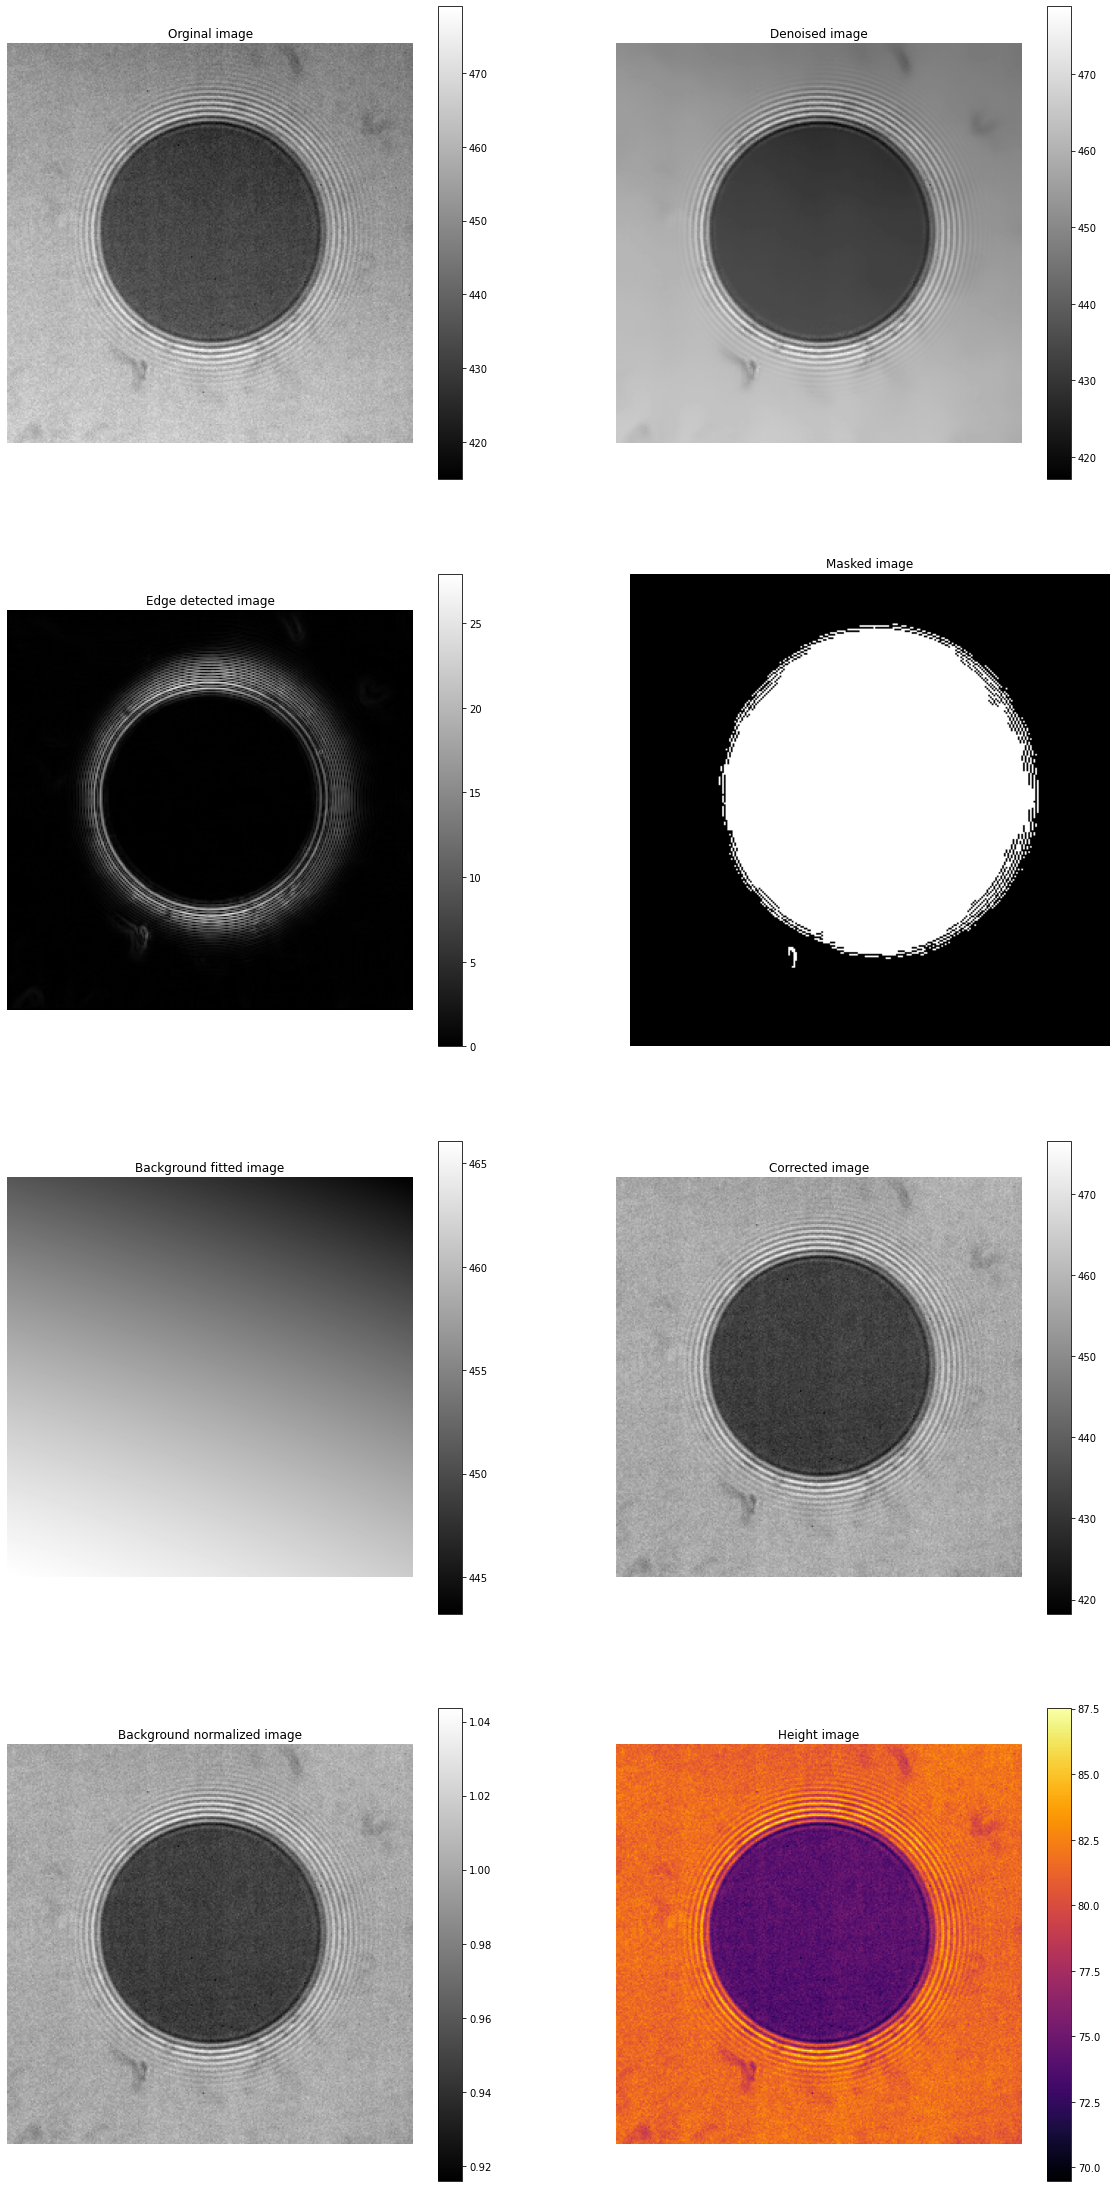

In [3]:
# display results
plt.figure(figsize=(20,40))

plt.subplot(421)
plt.axis('off')
plt.title('Orginal image')
plt.imshow(img, cmap = "gray")
plt.colorbar()

plt.subplot(422)
plt.axis('off')
plt.title('Denoised image')
plt.imshow(ricm.nl_denoise() , cmap = 'gray')
plt.colorbar()

plt.subplot(423)
plt.axis('off')
plt.title('Edge detected image')
plt.imshow(ricm.edge_detection() , cmap = 'gray')
plt.colorbar();

plt.subplot(424)
plt.axis('off')
plt.title('Masked image')
plt.imshow(ricm.mask() , cmap = 'gray')

plt.subplot(425)
plt.axis('off')
plt.title('Background fitted image')
plt.imshow(ricm.background_fitting() , cmap = 'gray')
plt.colorbar();

plt.subplot(426)
plt.axis('off')
plt.title('Corrected image')
plt.imshow(ricm.correct() , cmap = 'gray')
plt.colorbar()

plt.subplot(427)
plt.axis('off')
plt.title('Background normalized image')
plt.imshow(ricm.background_normalization() , cmap = 'gray')
plt.colorbar();

plt.subplot(428)
plt.axis('off')
plt.title('Height image')
plt.imshow(ricm.height() , cmap = 'inferno')
plt.colorbar();

# Save the image
#plt.savefig('Background subtracted image')

# Show the results
plt.show()

Y0 = 1.01, A = 0.24, h0 = 32.11


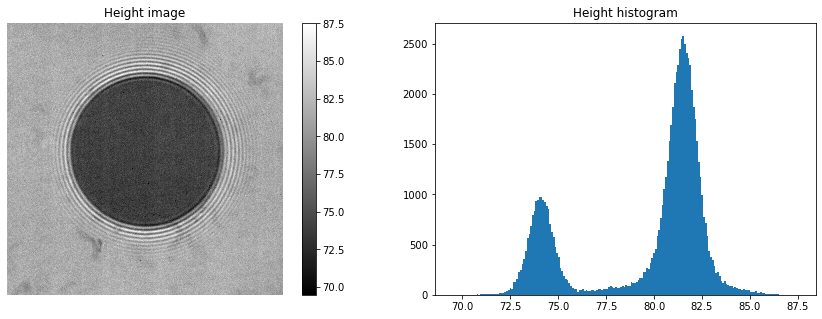

In [4]:
# Transform the image into int16 which is integer (-32768 to 32767)
img = ricm.height()

# display the image and it's histogram
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.axis('off')
plt.title('Height image')
plt.imshow(img, cmap = "gray")
plt.colorbar();

plt.subplot(122)
plt.title('Height histogram')
plt.hist(img.ravel(), bins = 200);
#plt.xlim(180,530)

Y0 = 1.01, A = 0.24, h0 = 32.11


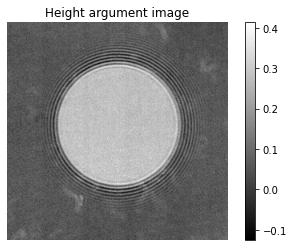

In [5]:
plt.axis('off')
plt.title('Height argument image')
plt.imshow(ricm.height_argument() , cmap = 'gray')
plt.colorbar();